In [3]:
import os
import numpy as np
import pandas as pd
import loompy as lp
import anndata as ad
import scanpy as sc

In [4]:
# set a working directory
out_dir = "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scenic/"
os.chdir( out_dir )

# path to unfiltered loom file (this will be created in the optional steps below)
# f_loom_path_unfilt = "pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "cluster1T2_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
#f_anndata_path = "anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'cluster1T2__scenic_integrated-output.loom'


In [11]:
file_path = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/GSM4006647_BC4_gene_cell_exprs_table.txt.gz'
df = pd.read_csv(file_path, sep='\t')
df.index = df.iloc[:, 0]
gene_symbols = df.iloc[:,:2]

# Drop the first two columns (Ensembl ID and gene name)
df = df.iloc[:, 2:]
# Transpose so that cells are rows and genes are columns
df = df.T

adata = ad.AnnData(df)

adata.obs['CellID']= df.index
adata.var[['Ensemble_ID','Gene']]= gene_symbols
adata.var.index= adata.var['Gene']
adata.var_names_make_unique() 
adata.var['mt'] =adata.var_names.str.startswith('MT-')

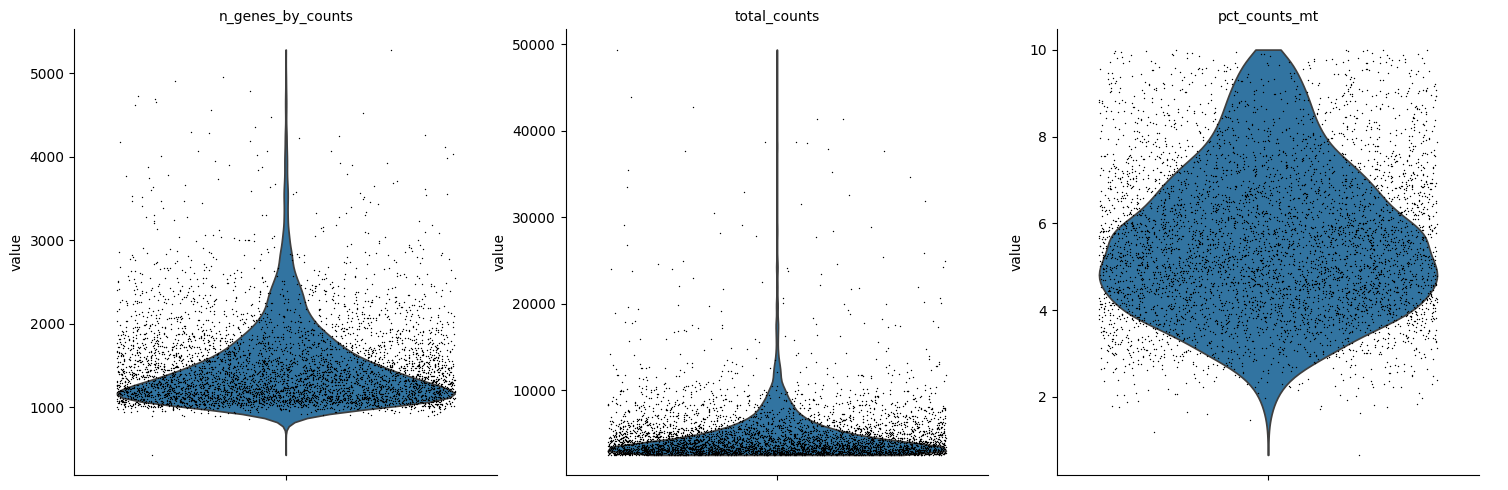

/tmp/ipykernel_155503/3357703206.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
adata= adata[adata.obs.n_genes_by_counts <6001, :]
#adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

adata.layers["counts"] = adata.X.copy()    

In [19]:
adata.obs['CellID']= adata.obs.index+'-GSM4006647_BC4'
#select cells 
indices_t2 = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', header=None)

indices_t2 = indices_t2.values.flatten()
adata_cluster1_T2 = adata[adata.obs['CellID'].isin(indices_t2)]


In [23]:
adata.obs['cell_type'] =0
adata.obs.loc[adata.obs['CellID'].isin(indices_t2), 'cell_type'] = 'Core'

/tmp/ipykernel_155503/9136849.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Core' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs['CellID'].isin(indices_t2), 'cell_type'] = 'Core'


In [ ]:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

row_attrs = {
    "Gene": np.array(adata_cluster1_T2.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_cluster1_T2.obs_names) ,
    "nGene": np.array( np.sum(adata_cluster1_T2.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_cluster1_T2.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata_cluster1_T2.X.transpose(), row_attrs, col_attrs)

In [24]:
adata.raw = adata  # keep full dimension safe

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


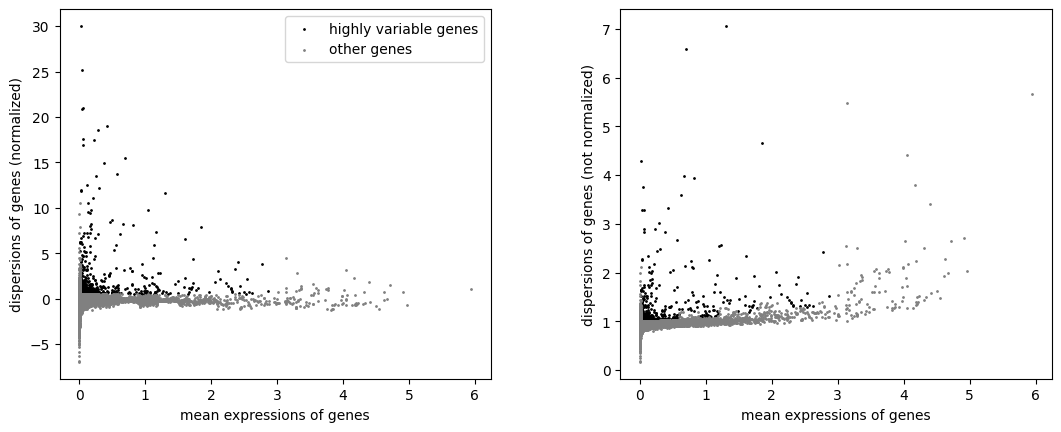

/home/jing/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)


/home/jing/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


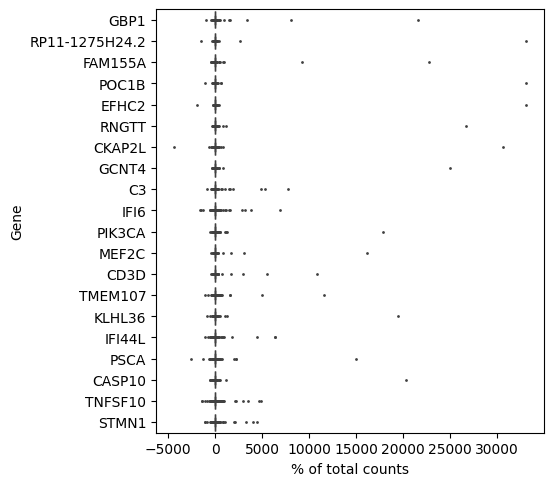

In [26]:
sc.pl.highest_expr_genes(adata, n_top=20)

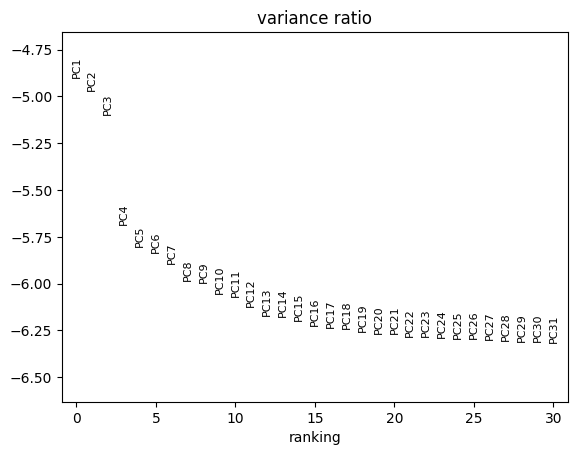

In [27]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)

/tmp/ipykernel_155503/3269956984.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=1)


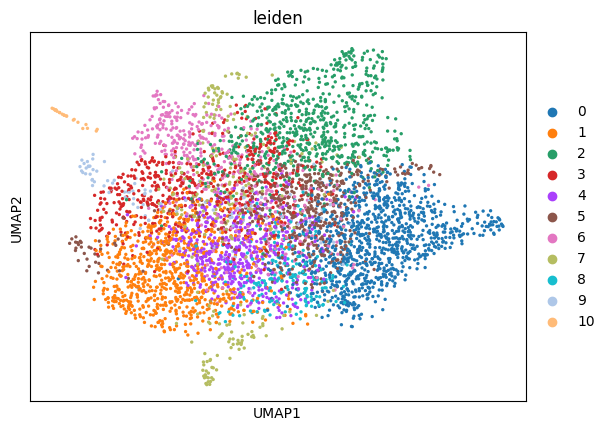

In [36]:
sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color=['leiden'] )

In [31]:
adata.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type
AAACCTGAGACACGAC.1,AAACCTGAGACACGAC.1-GSM4006647_BC4,1583,1583,4928,312,6.331169,0
AAACCTGAGTCCAGGA.1,AAACCTGAGTCCAGGA.1-GSM4006647_BC4,1198,1198,2973,150,5.045409,Core
AAACCTGCAATTCCTT.1,AAACCTGCAATTCCTT.1-GSM4006647_BC4,1038,1038,2605,139,5.335893,Core
AAACCTGCACGCTTTC.1,AAACCTGCACGCTTTC.1-GSM4006647_BC4,1693,1693,5518,181,3.280174,0
AAACCTGGTAAGGATT.1,AAACCTGGTAAGGATT.1-GSM4006647_BC4,3184,3184,13231,923,6.976041,0
...,...,...,...,...,...,...,...
TTTGTCATCACTTATC.1,TTTGTCATCACTTATC.1-GSM4006647_BC4,1135,1135,2910,79,2.714777,0
TTTGTCATCCGCATAA.1,TTTGTCATCCGCATAA.1-GSM4006647_BC4,1105,1105,2705,109,4.029575,0
TTTGTCATCCGGGTGT.1,TTTGTCATCCGGGTGT.1-GSM4006647_BC4,1149,1149,2967,87,2.932255,0
TTTGTCATCGCTTGTC.1,TTTGTCATCGCTTGTC.1-GSM4006647_BC4,1249,1249,3640,152,4.175824,Core


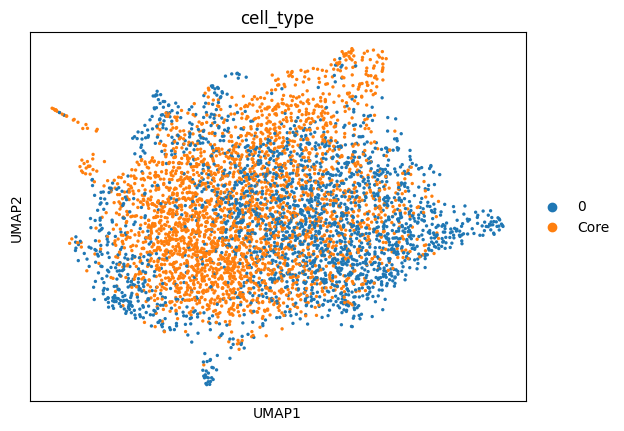

In [35]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
sc.pl.umap(adata, color='cell_type' )

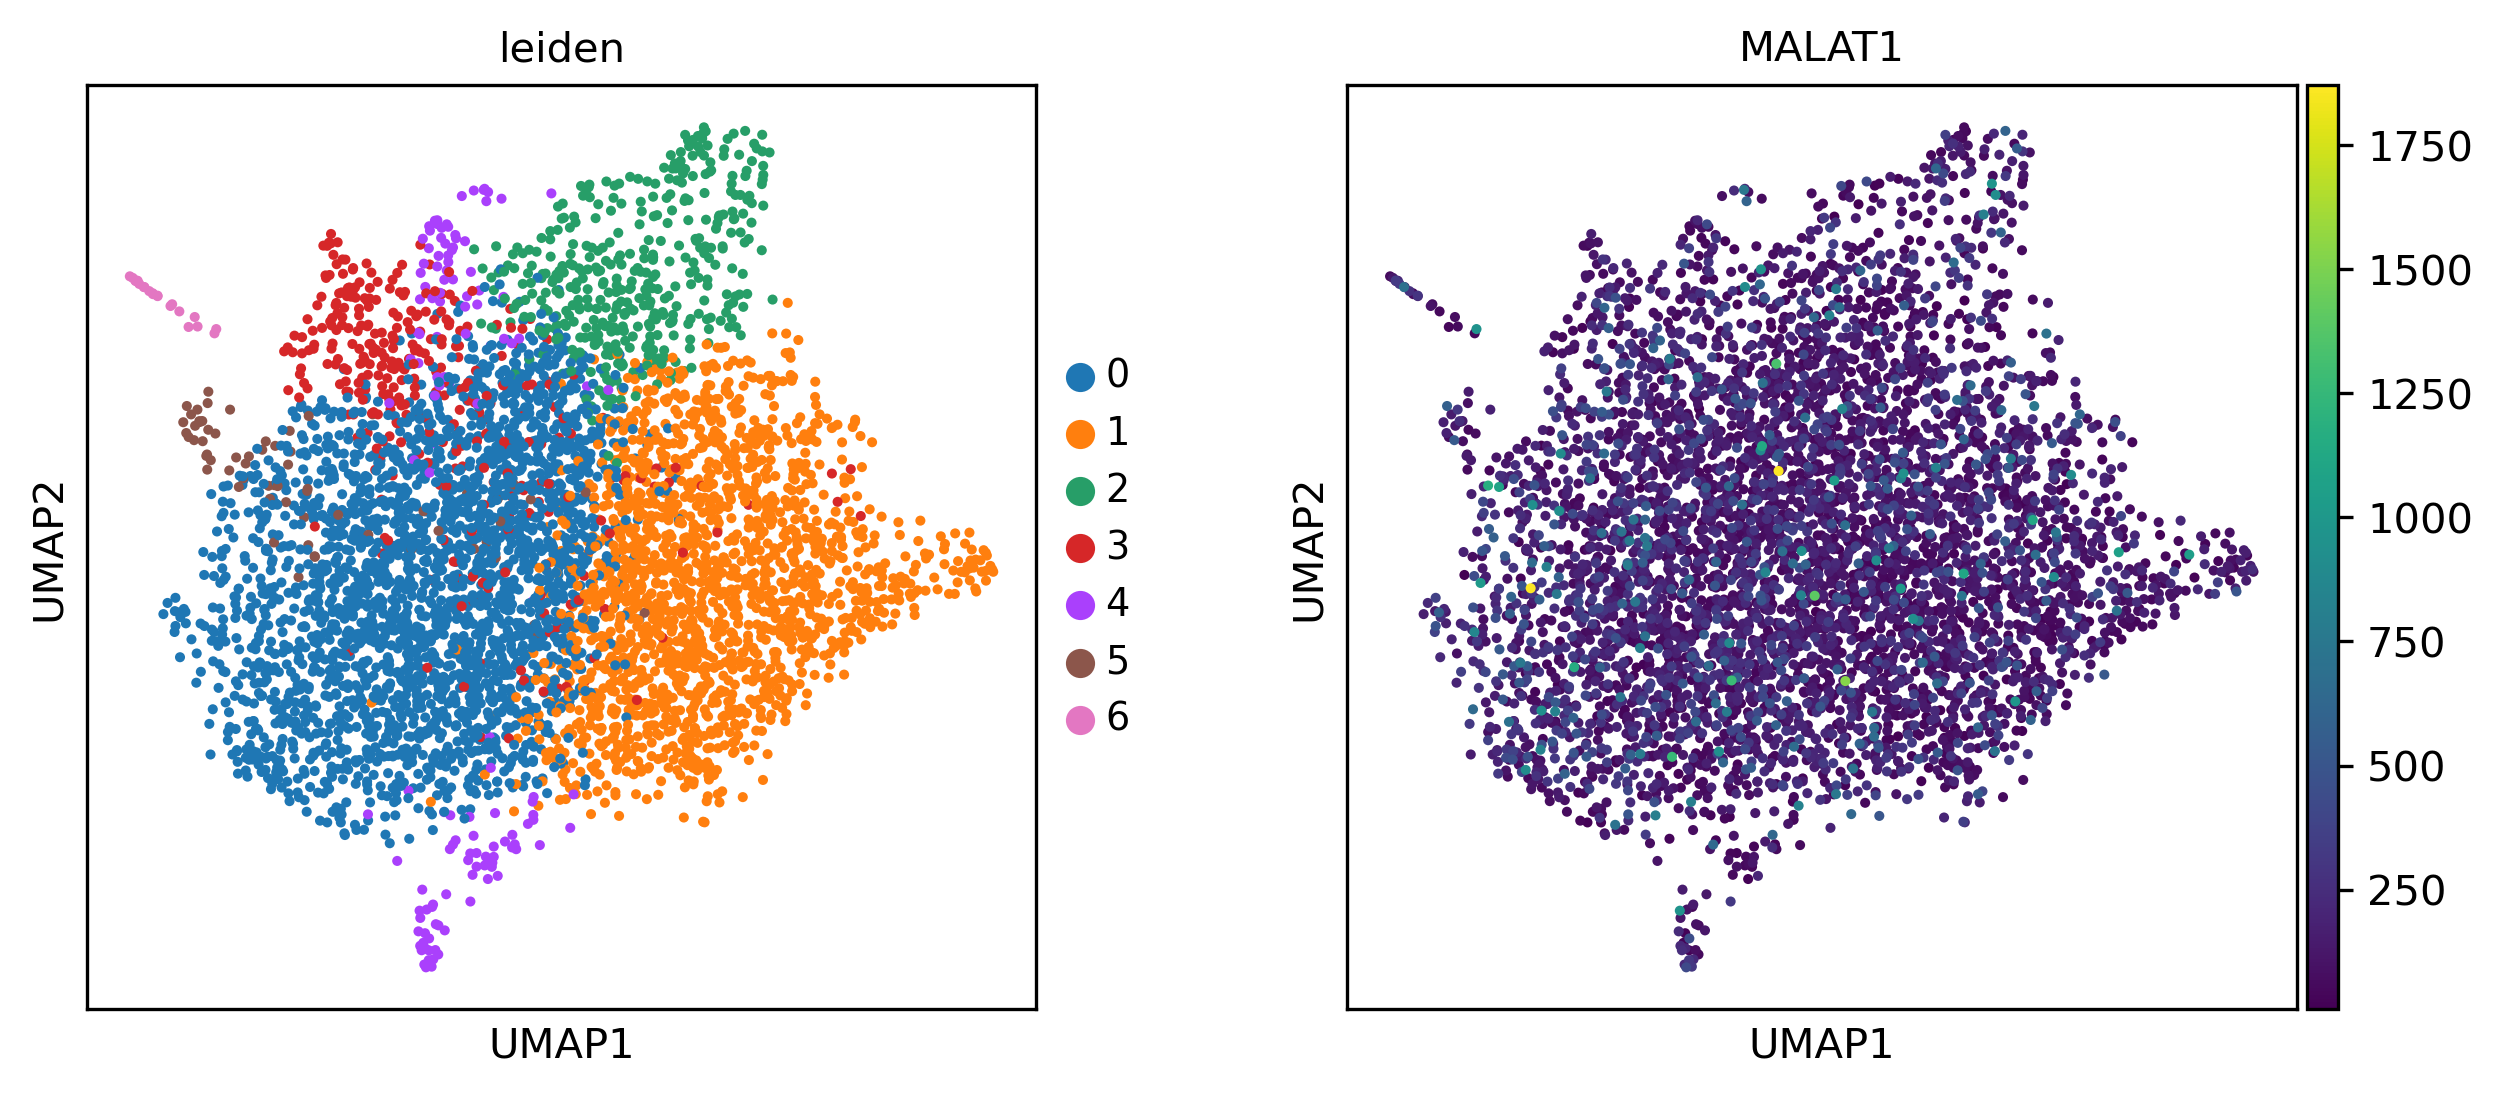

In [49]:
sc.pl.umap(adata, color=['leiden','MALAT1'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


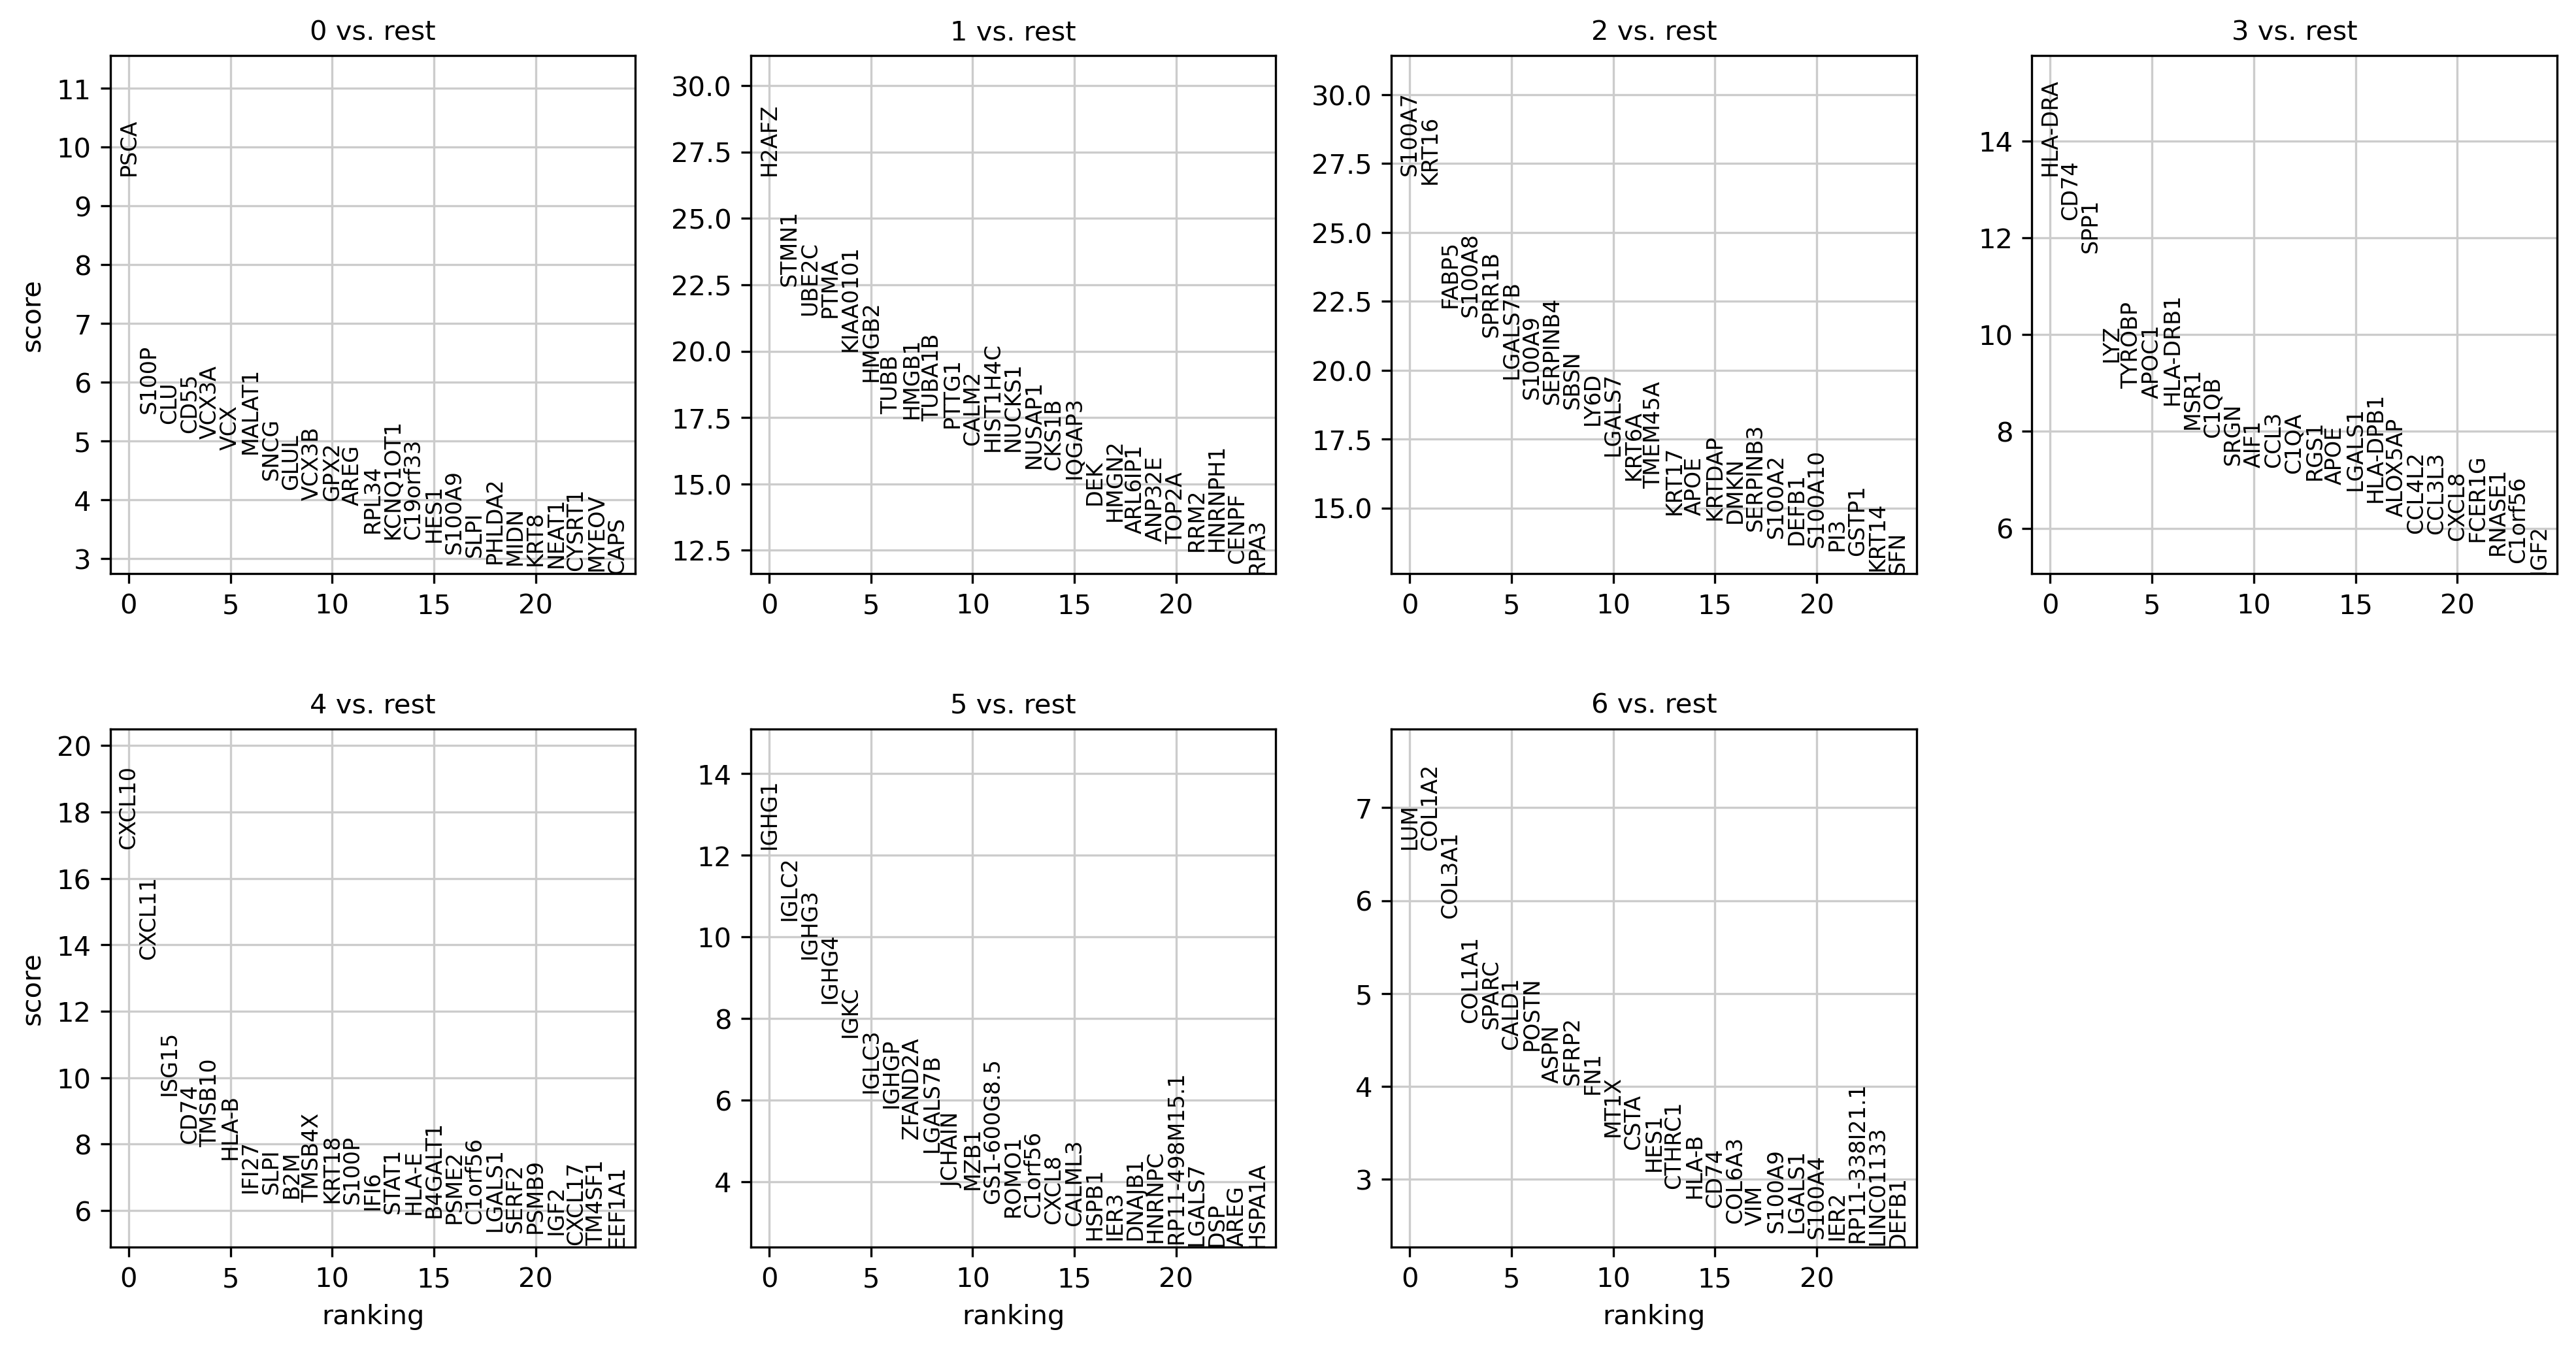

,0,1,2,3,4,5,6
0,PSCA,H2AFZ,S100A7,HLA-DRA,CXCL10,IGHG1,LUM
1,S100P,STMN1,KRT16,CD74,CXCL11,IGLC2,COL1A2
2,CLU,UBE2C,FABP5,SPP1,ISG15,IGHG3,COL3A1
3,CD55,PTMA,S100A8,LYZ,CD74,IGHG4,COL1A1
4,VCX3A,KIAA0101,SPRR1B,TYROBP,TMSB10,IGKC,SPARC
5,VCX,HMGB2,LGALS7B,APOC1,HLA-B,IGLC3,CALD1
6,MALAT1,TUBB,S100A9,HLA-DRB1,IFI27,IGHGP,POSTN
7,SNCG,HMGB1,SERPINB4,MSR1,SLPI,ZFAND2A,ASPN
8,GLUL,TUBA1B,SBSN,C1QB,B2M,LGALS7B,SFRP2
9,VCX3B,PTTG1,LY6D,SRGN,TMSB4X,JCHAIN,FN1


In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

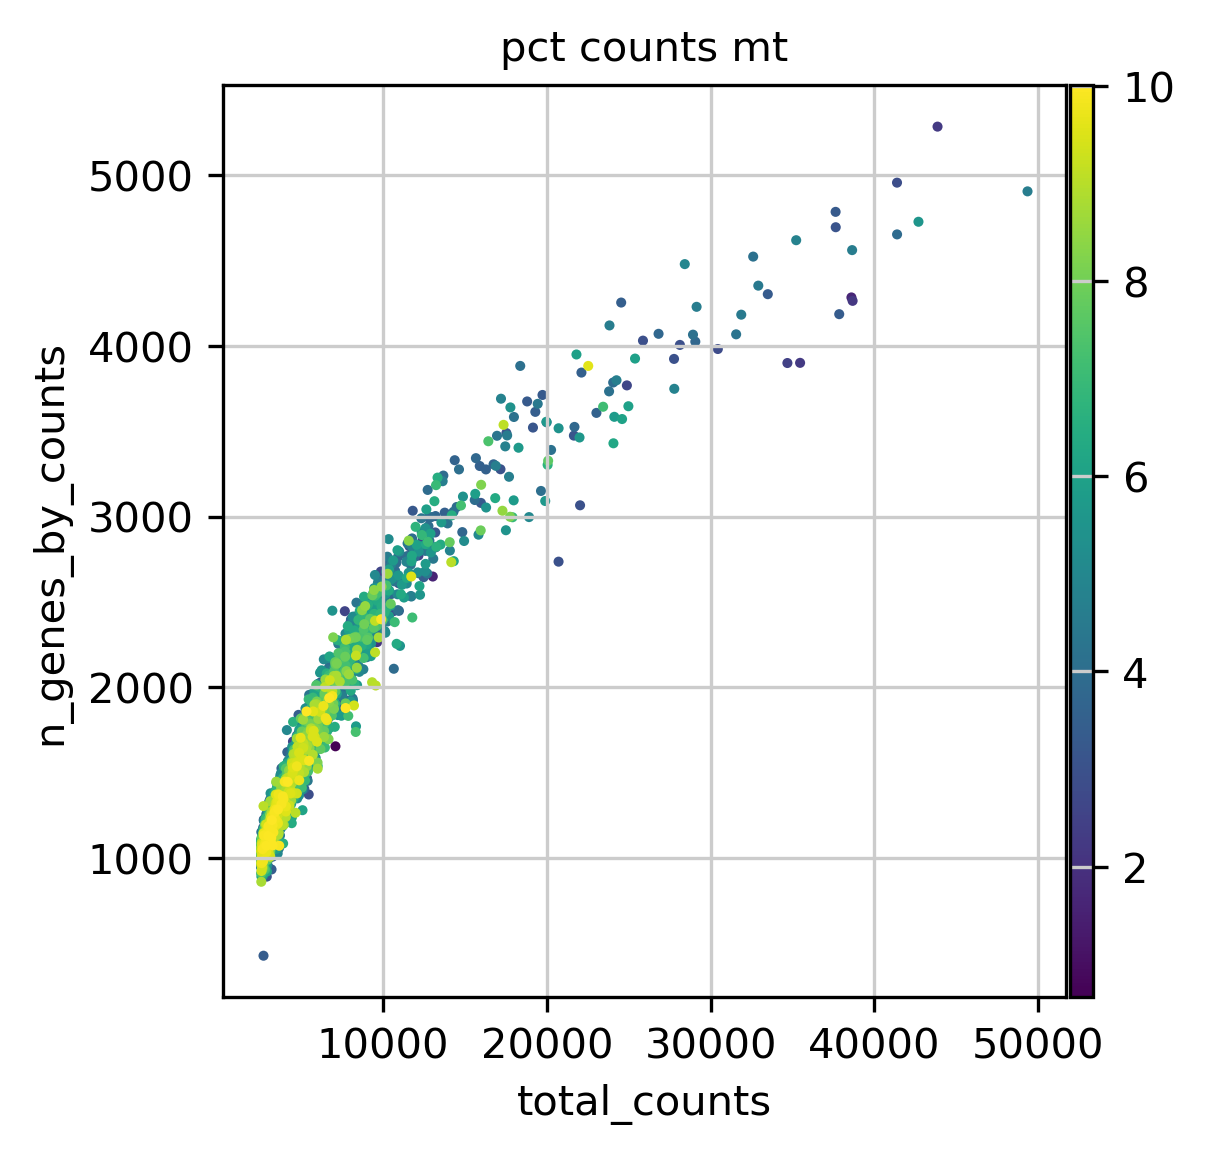

In [51]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')


## SCENIC steps


In [63]:
f_tfs = "/home/jing/Phd_project/phd_method/scenic/scenic_DATA/allTFs_hg38.txt" # human

from urllib.request import urlretrieve
url = 'https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
urlretrieve(url,'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather' )

url = 'https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'
urlretrieve(url,'motifs-v9-nr.hgnc-m0.001-o0.0.tbl' )

url_l='https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_tfs.txt'
urlretrieve(url_l,'hs_hgnc_tfs.txt')



DATABASES_GLOB = os.path.join("hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
MOTIFS_HGNC_FNAME = os.path.join('motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
CURATED_TFS_HGNC_FNAME = os.path.join('lambert2018.txt')

OUT_TFS_HGNC_FNAME = os.path.join('hs_hgnc_tfs.txt')
OUT_TFS_HGNC_FNAME = os.path.join('hs_hgnc_curated_tfs.txt')


In [80]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20


2025-04-30 15:02:44,810 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-04-30 15:02:45,247 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
not shutting down client, client was created externally
finished
Traceback (most recent call last):
  File "/home/jing/miniforge3/envs/cstar/bin/pyscenic", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/pyscenic/cli/pyscenic.py", line 713, in main
    args.func(args)
  File "/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/pyscenic/cli/pyscenic.py", line 106, in find_adjacencies_command
    network = method(
              ^^^^^^^
  File "/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/arboreto/algo.py", line 39, in grnboost2
    return diy(expression_data=expression_data, regressor_type='GBM', regressor_kwargs=SGBM_KWARGS,
           ^^^^^^^^^^^^^^^^^

In [5]:
out_dir = '~/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scenic'

In [7]:
adjacencies = pd.read_csv(os.path.join(out_dir,"adj.csv"), index_col=False, sep=',')

In [8]:
adjacencies

,TF,target,importance
0,ZNF555,ZNRF2,1.045621e+01
1,ZBTB7A,HSF2,9.887753e+00
2,ZNF333,CNDP2,9.798405e+00
3,PLAGL1,CPNE2,9.342536e+00
4,PARP1,ZNF71,9.338900e+00
...,...,...,...
1284062,FOSL1,CXCL8,2.677173e-17
1284063,AKR1A1,ZG16B,2.150245e-17
1284064,ZHX1,LYNX1,1.716110e-17
1284065,ATF6B,EIF3F,1.512309e-17


### STEP 2-3: Regulon prediction aka cisTarget from CLI

In [14]:
import glob
# ranking databases
f_db_names = 'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

# motif databases
f_motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"



In [15]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20


2025-04-30 19:15:25,791 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-04-30 19:15:26,105 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-04-30 19:15:26,874 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-04-30 19:15:26,970 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-04-30 19:15:35,801 - pyscenic.utils - INFO - Creating modules.

2025-04-30 19:15:49,574 - pyscenic.cli.pyscenic - IN

In [16]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20



2025-04-30 19:16:25,005 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-04-30 19:16:25,443 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-04-30 19:16:25,494 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-04-30 19:16:29,314 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [5]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
auc_mtx.to_pickle('auc_mtx.pickle')



In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
auc_mtx

,AHR(+),ATF6(+),CEBPD(+),CEBPG(+),CREB1(+),E2F1(+),EGR1(+),EP300(+),ETV2(+),FOS(+),...,TCF12(+),TEAD4(+),TFAP2C(+),TP53(+),YY1(+),ZNF117(+),ZNF557(+),ZNF580(+),ZNF585B(+),ZSCAN30(+)
AAACCTGAGTCCAGGA.1,0.099936,0.000000,0.101500,0.000000,0.019618,0.000000,0.078757,0.0,0.049968,0.056023,...,0.000000,0.021159,0.000000,0.000000,0.000000,0.009924,0.031800,0.0,0.062296,0.127066
AAACCTGCAATTCCTT.1,0.102828,0.000000,0.096928,0.142031,0.025639,0.000000,0.072581,0.0,0.000000,0.053521,...,0.089546,0.030552,0.076221,0.000000,0.000000,0.004245,0.052699,0.0,0.000000,0.016434
AAACCTGGTGTGACGA.1,0.024100,0.023907,0.115142,0.061375,0.004397,0.098972,0.078527,0.0,0.083226,0.059045,...,0.000000,0.006526,0.012725,0.027278,0.010640,0.010821,0.085642,0.0,0.031705,0.000092
AAACGGGCACCGAATT.1,0.000000,0.000000,0.120861,0.000000,0.020971,0.098604,0.057855,0.0,0.000000,0.053365,...,0.000000,0.030848,0.000000,0.054127,0.000000,0.000000,0.035180,0.0,0.000000,0.177562
AAACGGGGTCATATGC.1,0.147494,0.000000,0.103224,0.000000,0.018604,0.015975,0.073592,0.0,0.000000,0.053832,...,0.000000,0.049338,0.020308,0.000000,0.014353,0.000000,0.015948,0.0,0.000000,0.072438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCCGAGTC.1,0.000000,0.000000,0.121682,0.027635,0.000000,0.000000,0.065918,0.0,0.000000,0.060784,...,0.076907,0.000000,0.000000,0.012282,0.005427,0.000000,0.020137,0.0,0.000000,0.034337
TTTGTCAGTGATAAGT.1,0.000000,0.000000,0.112934,0.000000,0.038019,0.067022,0.074969,0.0,0.048683,0.058293,...,0.000000,0.012359,0.047429,0.000000,0.000000,0.004035,0.088356,0.0,0.000000,0.048935
TTTGTCATCACTGGGC.1,0.148136,0.043102,0.108277,0.125000,0.000000,0.093463,0.080066,0.0,0.000000,0.051642,...,0.076907,0.000000,0.024614,0.055556,0.000000,0.000000,0.030182,0.0,0.000000,0.009273
TTTGTCATCGCTTGTC.1,0.141067,0.039417,0.101462,0.000000,0.022460,0.080059,0.075774,0.0,0.000000,0.061397,...,0.053342,0.049436,0.022815,0.082976,0.023565,0.004125,0.041417,0.0,0.009083,0.088230


In [18]:
from pyscenic.rss import regulon_specificity_scores

In [19]:
rss_cellType = regulon_specificity_scores( auc_mtx )

TypeError: regulon_specificity_scores() missing 1 required positional argument: 'cell_type_series'

In [13]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

In [15]:
auc_mtx_Z

,AHR(+),ATF6(+),CEBPD(+),CEBPG(+),CREB1(+),E2F1(+),EGR1(+),EP300(+),ETV2(+),FOS(+),...,TCF12(+),TEAD4(+),TFAP2C(+),TP53(+),YY1(+),ZNF117(+),ZNF557(+),ZNF580(+),ZNF585B(+),ZSCAN30(+)
AAACCTGAGTCCAGGA.1,0.915755,-0.722240,-0.890514,-0.574419,0.043110,-0.977535,1.051241,-0.207301,0.953528,0.242586,...,-0.786578,-0.114769,-0.736263,-0.564891,-0.668760,0.405670,-0.566666,-0.32741,1.231193,2.004623
AAACCTGCAATTCCTT.1,0.960178,-0.722240,-1.371456,1.823138,0.343404,-0.977535,0.225001,-0.207301,-0.650034,-0.414074,...,1.057442,0.239181,4.564954,-0.564891,-0.668760,-0.292630,0.411035,-0.32741,-0.978390,-0.847961
AAACCTGGTGTGACGA.1,-0.249115,0.425322,0.544334,0.461630,-0.716060,0.914327,1.020479,-0.207301,2.020850,1.035789,...,-0.786578,-0.666186,0.148763,0.524302,-0.018371,0.515929,1.952196,-0.32741,0.146157,-1.269339
AAACGGGCACCGAATT.1,-0.619306,-0.722240,1.145844,-0.574419,0.110592,0.907307,-1.744962,-0.207301,-0.650034,-0.454885,...,-0.786578,0.250358,-0.736263,1.596387,-0.668760,-0.814518,-0.408541,-0.32741,-0.978390,3.306632
AAACGGGGTCATATGC.1,1.646267,-0.722240,-0.709219,-0.574419,-0.007501,-0.672170,0.360275,-0.207301,-0.650034,-0.332236,...,-0.786578,0.947082,0.676203,-0.564891,0.208611,-0.814518,-1.308294,-0.32741,-0.978390,0.596085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCCGAGTC.1,-0.619306,-0.722240,1.232281,-0.107926,-0.935376,-0.977535,-0.666314,-0.207301,-0.650034,1.492304,...,0.797162,-0.912089,-0.736263,-0.074469,-0.337018,-0.814518,-1.112309,-0.32741,-0.978390,-0.386340
TTTGTCAGTGATAAGT.1,-0.619306,-0.722240,0.312063,-0.574419,0.960862,0.303596,0.544454,-0.207301,0.912279,0.838465,...,-0.786578,-0.446365,2.562471,-0.564891,-0.668760,-0.318357,2.079141,-0.32741,-0.978390,-0.009941
TTTGTCATCACTGGGC.1,1.656139,1.346662,-0.177744,1.535648,-0.935376,0.809028,1.226349,-0.207301,-0.650034,-0.907058,...,0.797162,-0.912089,0.975682,1.653413,-0.668760,-0.814518,-0.642388,-0.32741,-0.978390,-1.032610
TTTGTCATCGCTTGTC.1,1.547549,1.169797,-0.894503,-0.574419,0.184822,0.552802,0.652122,-0.207301,-0.650034,1.653159,...,0.311893,0.950807,0.850527,2.748308,0.771700,-0.307331,-0.116790,-0.32741,-0.656223,1.003259


In [14]:


def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f



In [ ]:


sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")





/home/jing/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jing/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


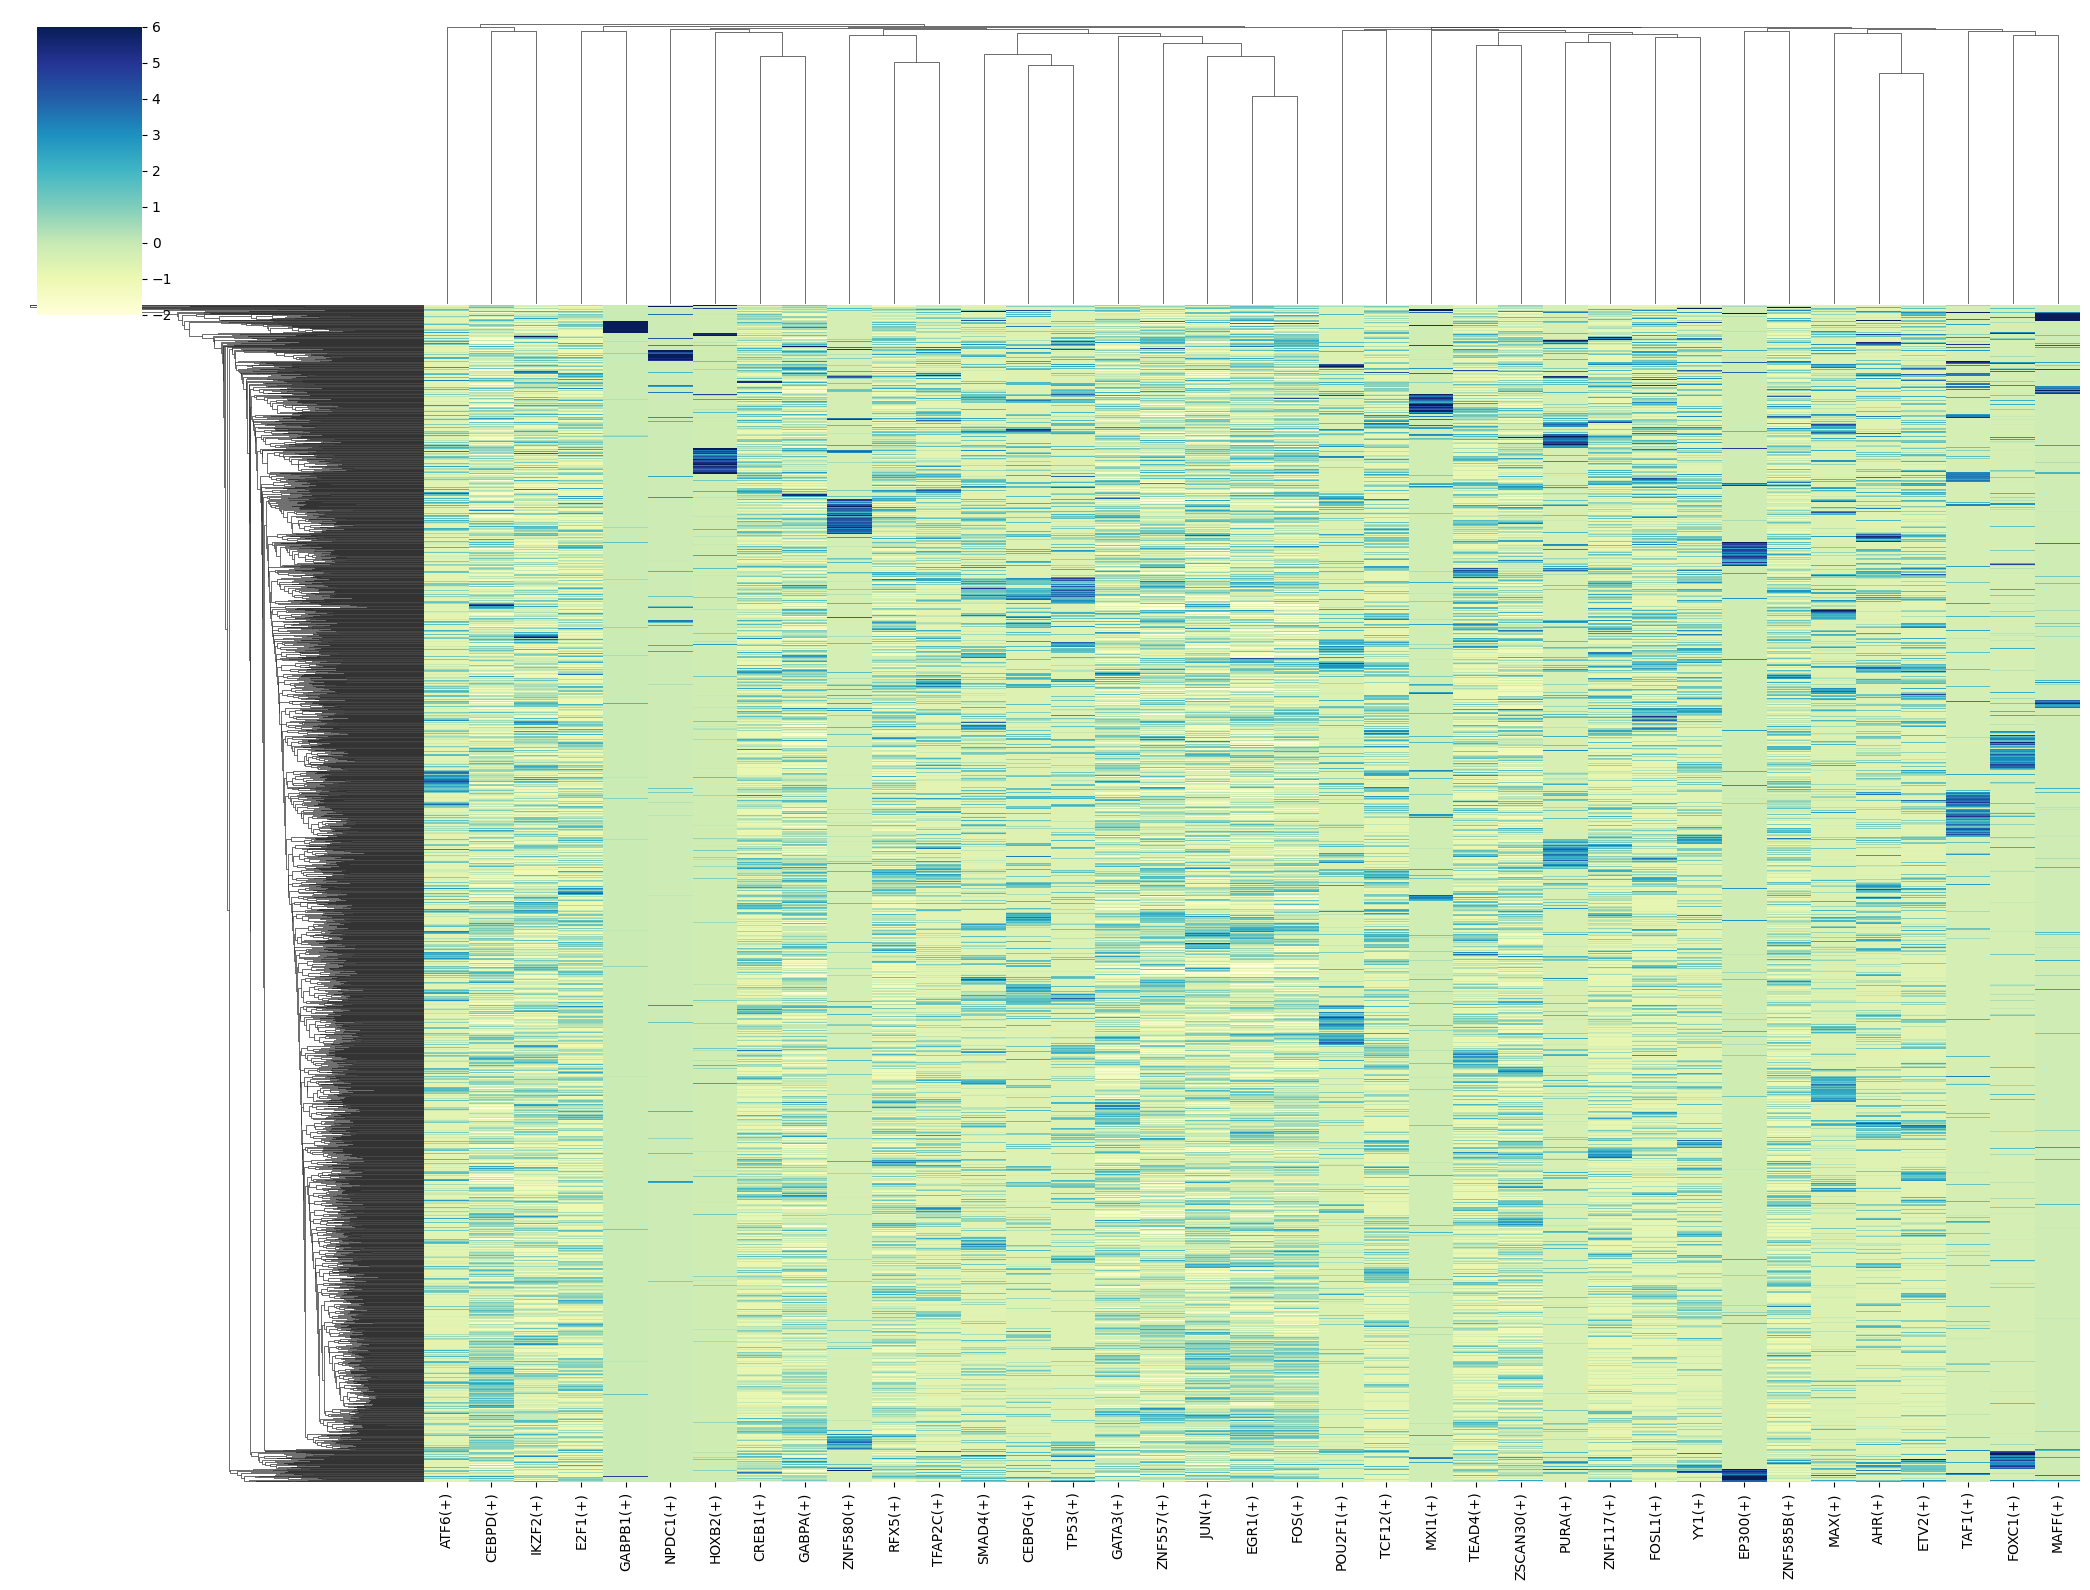

In [17]:
sns.clustermap(auc_mtx_Z, annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, 
    cmap="YlGnBu", figsize=(21,16) )

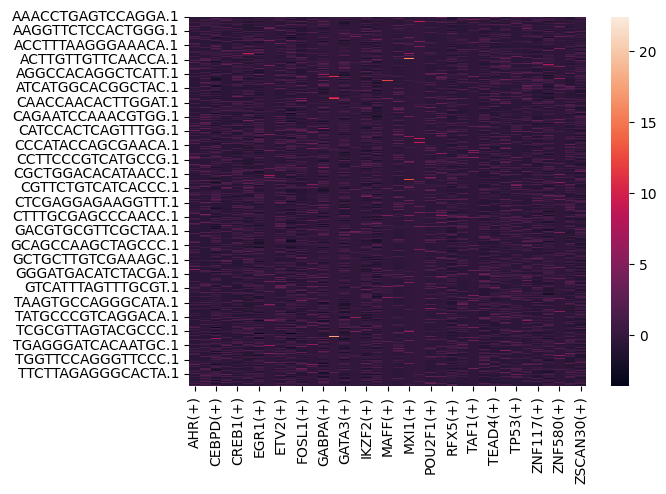

In [16]:
sns.heatmap(auc_mtx_Z)
    
plt.show()


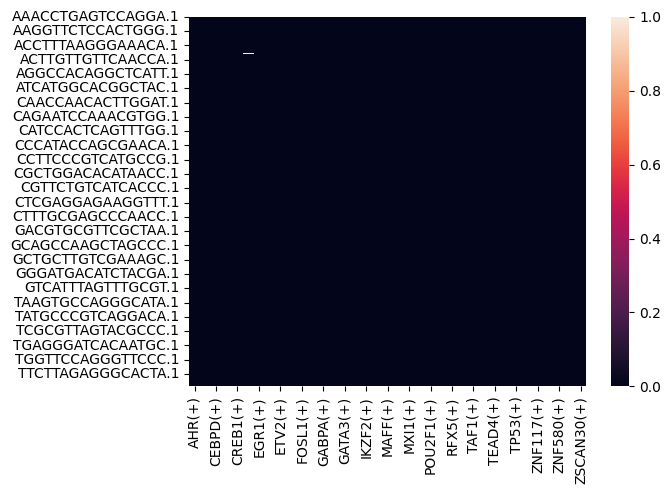

In [10]:
binarized_matrix = auc_mtx > 0.5
    
    # Create a heatmap using seaborn


In [5]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')


In [6]:


# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
###



In [7]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )



In [ ]:


tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']



In [1]:
from MulticoreTSNE import MulticoreTSNE as TSNE

ModuleNotFoundError: No module named 'MulticoreTSNE'

In [8]:


def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr



In [16]:
col_attrs = {
    "CellID": np.array(adata_cluster1_T2.obs.index),
    "nUMI": np.array(adata_cluster1_T2.obs['n_counts'].values),
    "nGene": np.array(adata_cluster1_T2.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata_cluster1_T2.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata_cluster1_T2.obs['percent_mito'].values),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

KeyError: 'n_counts'